In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns





CONNECTIVITY_MATRIX_SHAPE: (360, 1200)
BRAIN_REGION_INFO: (360, 12)
                          region region_abbrev hemi  region_idx  \
0          Primary Visual Cortex            V1    R           0   
1  Medial Superior Temporal Area           MST    R           1   
2              Sixth Visual Area            V6    R           2   
3             Second Visual Area            V2    R           3   
4              Third Visual Area            V3    R           4   

            network network_abbrev  network_idx  network_region_idx  \
0    Primary Visual           VIS1            1                   4   
1  Secondary Visual           VIS2            2                  97   
2  Secondary Visual           VIS2            2                  98   
3  Secondary Visual           VIS2            2                  99   
4  Secondary Visual           VIS2            2                 100   

  network_colour      mni_x      mni_y      mni_z  
0      royalblue -12.684422 -82.321608   1.542622 

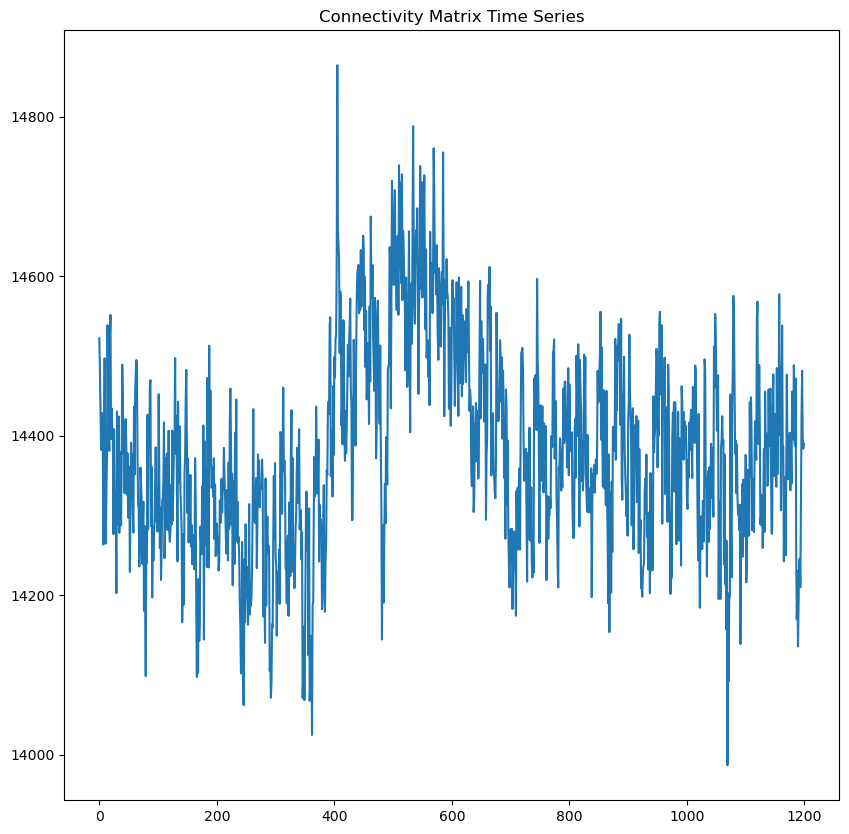

In [6]:
path_conn = '../data/hcp/raw/100206_0.npy'
path_brain_region = '../data/brain_regions.csv'

# Load the connectivity matrix
connectivity_matrix = np.load(path_conn)

# Load the brain regions
brain_regions = pd.read_csv(path_brain_region)

# Check the shape of your connectivity matrix
print("CONNECTIVITY_MATRIX_SHAPE:", connectivity_matrix.shape)
print("BRAIN_REGION_INFO:", brain_regions.shape)

# Check the first few rows of your brain regions data
print(brain_regions.head())

# Basic visualization of the connectivity matrix
# plt.figure(figsize=(10, 10))
# sns.heatmap(connectivity_matrix, cmap='viridis')
# plt.title('Connectivity Matrix')
# plt.show()

plt.figure(figsize=(10, 10))
plt.plot(connectivity_matrix[359])
plt.title('Connectivity Matrix Time Series')
plt.show()



SCAN_SHAPE:  (360, 490)
FC_MATRIX_SHAPE: (16, 360, 360)


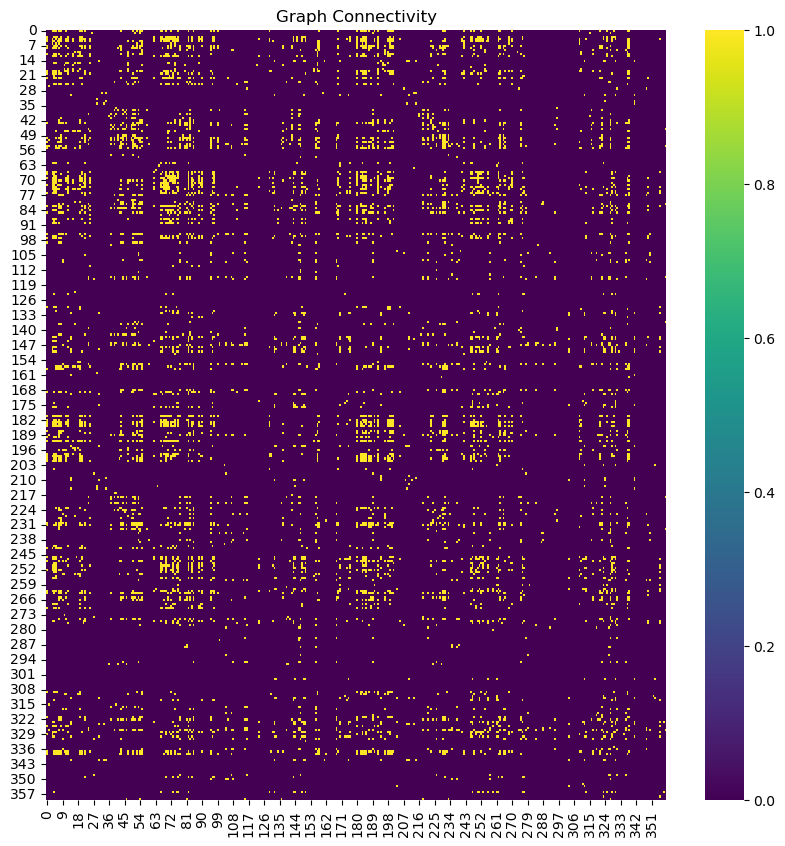

In [7]:
scan = np.load(path_conn)[:, :490]
print('SCAN_SHAPE: ', scan.shape)

def create_fc_matrices(scan, window_size=30, step_size=30):
    """
    Create functional connectivity matrices using a sliding window approach.
    """
    n_timepoints = scan.shape[1]
    fc_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window = scan[:, start:start + window_size]
        correlation_matrix = np.corrcoef(window)
        fc_matrices.append(correlation_matrix)

    return fc_matrices

# Example of processing one scan
fc_matrices = create_fc_matrices(scan)
print('FC_MATRIX_SHAPE:', np.array(fc_matrices).shape)

def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph

# Example of thresholding one FC matrix
graphs = [threshold_fc_matrix(fc) for fc in fc_matrices]     # --> ho 16 grafi, per ogni time_window (30)

# Heatmap of one graph of 16
plt.figure(figsize=(10, 10))
sns.heatmap(graphs[0], cmap='viridis')
plt.title('Graph Connectivity')
plt.show()

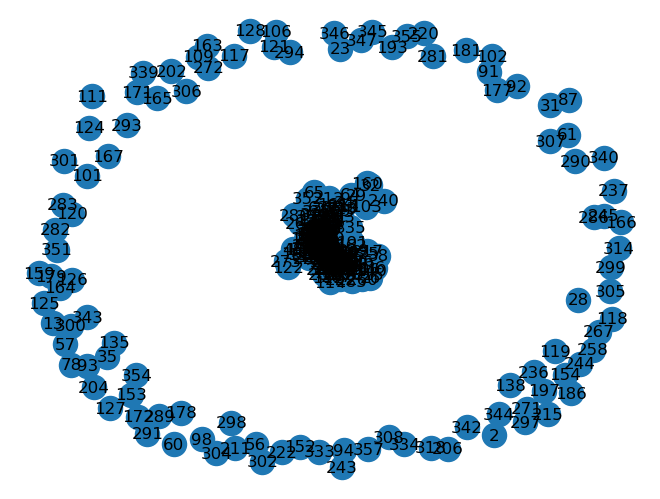

GRAPHS_SHAPE: (16, 360, 360)


In [8]:
import networkx as nx

def create_networkx_graph(matrix):
    G = nx.Graph(matrix)
    return G

# Visualize one graph using NetworkX
G = create_networkx_graph(graphs[0])
nx.draw(G, with_labels=True)
plt.show()
print("GRAPHS_SHAPE:" ,np.array(graphs).shape)


In [9]:
from torch_geometric.data import Data

def convert_to_pyg_graph(nx_graph):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    
    # For unsupervised learning, you typically don't have node labels
    # If you have node features, replace x with them
    return Data(x=x, edge_index=edges)


In [10]:
pyg_graphs = [convert_to_pyg_graph(g) for g in graphs]

for i in range(len(pyg_graphs)):
    print(pyg_graphs[i])

# --> ogni regione può essere connessa al 5% dei nodi, (((N-1) * N)/2) * 5/100



Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
Data(x=[360, 360], edge_index=[2, 3231])
